In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import bioframe
import numpy as np
import seaborn as sns
from pybedtools import BedTool
import re

In [75]:
gm = "/pollard/home/lchumpitaz/Hi-C/testing/annotations/GM12878.csv"

In [133]:
gm_df = pd.read_csv(gm)
# gm_df['HMM5_2'] = gm_df['HMM5_2'].fillna(-1)
# gm_df['HMM5_2'] = gm_df['HMM5_2'].astype(int)
gm_df.head()

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM4,HMM5,HMM6,HMM5_2
0,chr1,0,50000,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,NaN,0.447314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,NaN,0.410796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ChromHMM

In [134]:
chrom_hmm_dir = '/pollard/data/wynton/consortia/roadmap/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final'

In [135]:
chrom_gm =  chrom_hmm_dir+'/E116_15_coreMarks_dense.bed.gz'

In [136]:
chrom_gm_df= BedTool(chrom_gm).to_dataframe(skiprows=1)

In [137]:
from bioframe.util import bedtools
def bedtools_intersect_basePairs(left, right, rsuffix='_', **kwargs):
    """
    >>> ixn = bedtools_intersect(bed1, bed2, wao=True), needed to delete other keys b/c they clashed
   """
    
    out = bedtools.intersect(a=left, b=right,wao=True)
    out.columns = list(left.columns) + [c+rsuffix if c in left.columns else c for c in right.columns] + ['bpOverlap']
    return out

In [144]:
inter_gm = bedtools_intersect_basePairs(gm_df, chrom_gm_df)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (19,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [145]:
inter_gm.head()

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,...,chrom_,start_,end_,name,score,strand,thickStart,thickEnd,itemRgb,bpOverlap
0,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,chr1,0,9800,15_Quies,0,.,0,9800,"255,255,255",9800
1,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,chr1,9800,10600,9_Het,0,.,9800,10600,"138,145,208",800
2,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,chr1,10600,235600,15_Quies,0,.,10600,235600,"255,255,255",39400
3,chr1,50000,100000,NaN,0.37674,NaN,NaN,NaN,NaN,NaN,...,chr1,10600,235600,15_Quies,0,.,10600,235600,"255,255,255",50000
4,chr1,100000,150000,NaN,0.42996,NaN,NaN,NaN,NaN,NaN,...,chr1,10600,235600,15_Quies,0,.,10600,235600,"255,255,255",50000


In [153]:
def bp_over_state(inter_df, hmm_track, hmm_state='HMM3', chrom=False, chrom_state = False, normalize = True, n_states=None, bp=True):
    
    if n_states == None:
        n_states = inter_df[hmm_state].unique()
        n_states = n_states[n_states == n_states]
        n_states.sort()
    
    mask = (inter_df['start']!=-1) & (~inter_df[hmm_state].isna())
    
    if chrom_state:        
        mask = mask & (inter_df['name']==chrom_state)
    
    if chrom:
        mask= mask & (inter_df['chrom']==chrom)
        hmm_track= hmm_track[hmm_track['chrom'] == chrom]
    
    if bp:
        total_nucleotides = inter_df['bpOverlap']
        
    else:
        total_nucleotides = (inter_df['end_'] - inter_df['start_'])
        
    if normalize:
        return np.array([total_nucleotides[(inter_df[hmm_state]==state) & mask].sum()/(len(hmm_track[hmm_track[hmm_state]==state])) for state in n_states])/ (total_nucleotides[mask].sum()/len(hmm_track))
    
    else:
        return np.array([total_nucleotides[(inter_df[hmm_state]==state) & mask].sum()/(100000*len(hmm_track[hmm_track[hmm_state]==state])) for state in n_states])

In [151]:
chrom_states = list(inter_gm.name.unique()[:-1])
chrom_states.sort(key=lambda x:int(re.findall('[0-9]+', x)[0]))
chrom_states

['1_TssA',
 '2_TssAFlnk',
 '3_TxFlnk',
 '4_Tx',
 '5_TxWk',
 '6_EnhG',
 '7_Enh',
 '8_ZNF/Rpts',
 '9_Het',
 '10_TssBiv',
 '11_BivFlnk',
 '12_EnhBiv',
 '13_ReprPC',
 '14_ReprPCWk',
 '15_Quies']

In [148]:
hmm_states = ['B', 'Mbb', 'M', 'Maa', 'A', 'N']

In [156]:
bp_over_state(inter_gm, gm_df, hmm_state='HMM5_2', chrom_state = '15_Quies', normalize = True, n_states=None, bp=True)

array([1.59038654, 1.10793856, 1.1083716 , 1.14538152, 0.65515118])

# GC content and E1

In [8]:
masked_track = gm_df[~gm_df['E1'].isna()]

In [9]:
def get_state_values(hmm_track, hmm, signal,  states = False, clip = False):
    if not states:
        states = hmm_track[hmm].unique()
        states.sort()
    l = []
    for state in states:
        vals = hmm_track[hmm_track[hmm] == state][signal].values
        if clip:
            vals = np.clip(vals, np.percentile(vals, 1), np.percentile(vals, 99))
        l.append(vals)
    return l

In [10]:
gc_states = get_state_values(masked_track, 'HMM5_2','GC')

In [11]:
labels=['B', 'Mbb', 'M', 'Maa', 'A']

Text(0.5, 1.0, 'GC coverage')

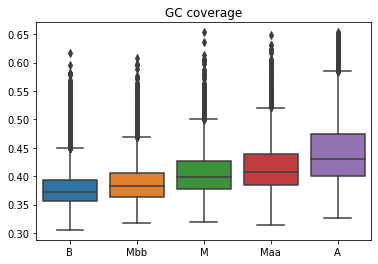

In [12]:
sns.boxplot(data=gc_states)
plt.gca().set_xticklabels(labels);
plt.title('GC coverage')

In [13]:
E1_states = get_state_values(masked_track, 'HMM5_2','E1')

Text(0.5, 1.0, 'GC coverage')

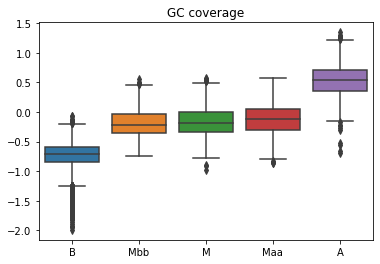

In [14]:
sns.boxplot(data=E1_states)
plt.gca().set_xticklabels(labels);
plt.title('GC coverage')

# Gene expression

In [15]:
gencode = pd.read_csv('../gencode.v26lift37.annotation.gtf.gz',
               names=['chrom','annot','type','start','stop','na1','strand','na2','genestuff'],
                      delimiter='\t',skiprows=5)
genes = gencode.loc[gencode['type'].values=='gene']
genes.rename(columns={'stop':'end'}, inplace=True)
genes.astype({'start':int,'end':int})
### need to join gene table & expression table
geneNames =  genes['genestuff'].str.split('; ')
genes['Description'] = [i[2].split(' ')[1].replace('"','') for i in geneNames]
genes['Name'] = [i[0].split(' ')[1].replace('"','').split('_')[0] for i in geneNames]
genes.head()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,chrom,annot,type,start,end,na1,strand,na2,genestuff,Description,Name
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; gene_type ""tran...",DDX11L1,ENSG00000223972.5
12,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5_2""; gene_type ""unpr...",WASH7P,ENSG00000227232.5
25,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5_3""; gene_type ""linc...",MIR1302-2HG,ENSG00000243485.5
33,chr1,HAVANA,gene,34554,36081,.,-,.,"gene_id ""ENSG00000237613.2_2""; gene_type ""linc...",FAM138A,ENSG00000237613.2
41,chr1,HAVANA,gene,52473,53312,.,+,.,"gene_id ""ENSG00000268020.3_2""; gene_type ""unpr...",OR4G4P,ENSG00000268020.3


In [16]:
expression = pd.read_csv('../GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
               ,delimiter='\t', skiprows = 2)
expression.head()

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743
2,ENSG00000278267.1,MIR6859-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000243485.5,MIR1302-2HG,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.054223,0.00000,0.00000,0.00000,0.00000
4,ENSG00000237613.2,FAM138A,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000


In [17]:
t = expression.set_index('Name').join(genes.set_index('Name'),rsuffix='_')

In [18]:
expressed_genes = t.copy()
expressed_genes.reset_index(inplace=True)
expressed_genes = expressed_genes[['chrom','start','end','strand','Cells - EBV-transformed lymphocytes']]
expressed_genes = expressed_genes.iloc[~pd.isnull(expressed_genes['chrom'].values)]
expressed_genes.sort_values(['chrom','start','end'],inplace=True)
expressed_genes['start'] = expressed_genes['start'].values.astype(int) #since just using .astype() method wasn't working..
expressed_genes['end'] = expressed_genes['end'].values.astype(int)
expressed_genes = expressed_genes[expressed_genes['chrom'].isin(gm_df.chrom.unique())] #Filters out chroms not available in Hi-C HMM

In [19]:
expressed_genes

,chrom,start,end,strand,Cells - EBV-transformed lymphocytes
24924,chr1,11869,14409,+,0.000000
27175,chr1,14404,29570,-,2.494770
36655,chr1,29554,31109,+,0.000000
34236,chr1,34554,36081,-,0.000000
49061,chr1,52473,53312,+,0.000000
...,...,...,...,...,...
24582,chrY,59318041,59318920,-,0.000000
5502,chrY,59330252,59343488,+,2.231860
15906,chrY,59347294,59349508,-,0.048374
15238,chrY,59353497,59358381,+,4.450780


In [20]:
intersection = bedtools_intersect_basePairs(gm_df, expressed_genes)

In [21]:
intersection.head()

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,...,HMM4,HMM5,HMM6,HMM5_2,chrom_,start_,end_,strand,Cells - EBV-transformed lymphocytes,bpOverlap
0,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,11869,14409,+,0.00000,2540
1,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,29554,31109,+,0.00000,1555
2,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,34554,36081,-,0.00000,1527
3,chr1,0,50000,NaN,0.48425,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,14404,29570,-,2.49477,15166
4,chr1,50000,100000,NaN,0.37674,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,52473,53312,+,0.00000,839


In [22]:
mask = (intersection['E1'] == intersection['E1']) & (intersection['Cells - EBV-transformed lymphocytes']>0)

In [23]:
data = []
for i in range(5):
    track = intersection[(mask)&(intersection["HMM5_2"]==i)]['Cells - EBV-transformed lymphocytes'].values
    data.append(np.log(track))

Text(0.5, 1.0, 'Gene expression')

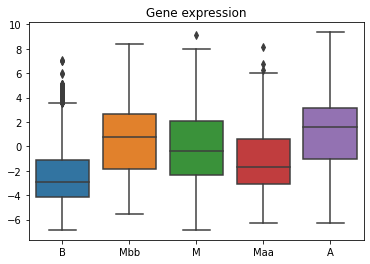

In [24]:
sns.boxplot(data=data)
plt.gca().set_xticklabels(labels);
plt.title('Gene expression')